In [23]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

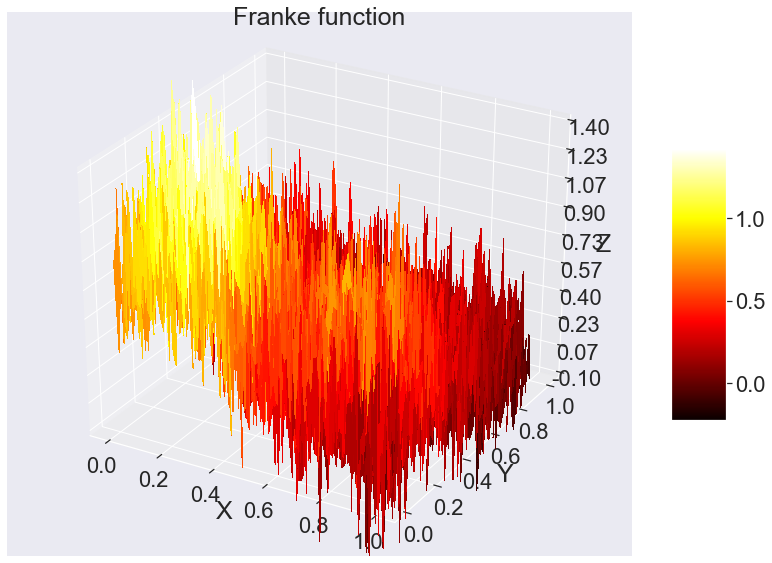

(10000, 21)


In [24]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.25
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 

from mpl_toolkits.mplot3d import Axes3D 
fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, frank, cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,5)
print(design.shape)





In [ ]:
epochs=2000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=2000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

test_loss = test_loss/k
test_r2 = test_r2/k

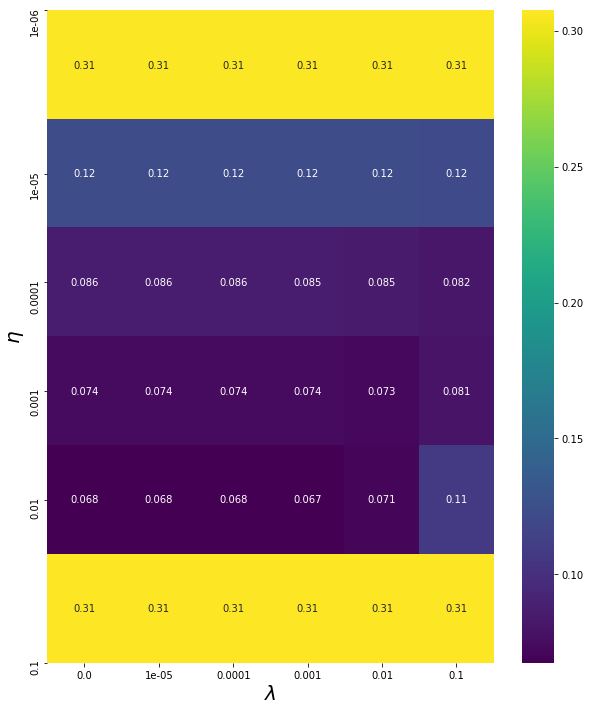

In [5]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

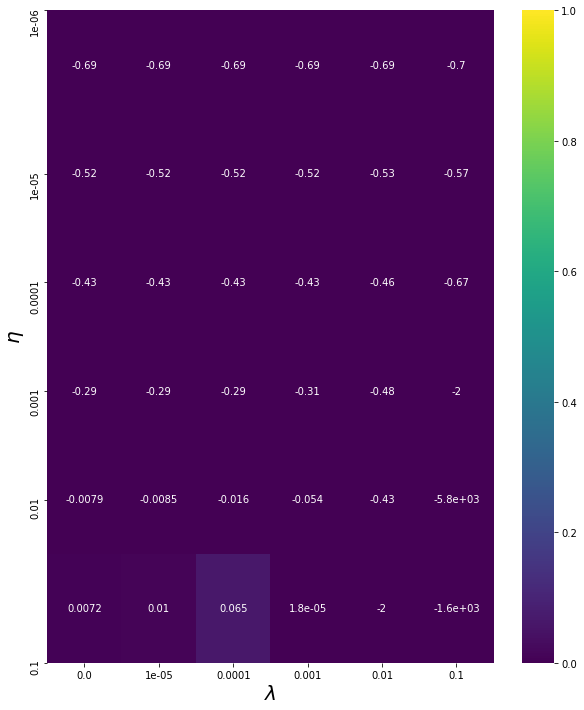

In [5]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin=0, vmax=1)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [6]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

eta= [0.1]
lmb= [0.001]


In [18]:
test_loss_best = 0
test_r2_best = 0
k=5

activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact_deriv]
epochs= 2000
for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 0,\
                                early_stop_nochange=1500, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(ytest.ravel(),pred.ravel())
            test_r2_best +=  fx.R2Score(ytest.ravel(),pred.ravel())

test_loss_best /= k
test_r2_best /= k
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

Epoch 1 loss 0.19622813545847204
Epoch 2 loss 0.18470066480584585
Epoch 3 loss 0.17462188021909056
Epoch 4 loss 0.16591776044210194
Epoch 5 loss 0.1585505091523473
Epoch 6 loss 0.15173400390053424
Epoch 7 loss 0.14564426427701244
Epoch 8 loss 0.14029313845713368
Epoch 9 loss 0.13526231006311787
Epoch 10 loss 0.13084213301155073
Epoch 11 loss 0.1264518728114717
Epoch 12 loss 0.12267913308751713
Epoch 13 loss 0.11949243210526393
Epoch 14 loss 0.11583977911711327
Epoch 15 loss 0.11302988806909608
Epoch 16 loss 0.11045676732792245
Epoch 17 loss 0.10776270058622152
Epoch 18 loss 0.10560271003286098
Epoch 19 loss 0.10398351611859288
Epoch 20 loss 0.10278372946187468
Epoch 21 loss 0.10021818005210122
Epoch 22 loss 0.09874434439610348
Epoch 23 loss 0.09745591909173305
Epoch 24 loss 0.0964192041811262
Epoch 25 loss 0.09534196571114115
Epoch 26 loss 0.09442603250088351
Epoch 27 loss 0.0938184787803877
Epoch 28 loss 0.09296726768978061
Epoch 29 loss 0.09239611890146478
Epoch 30 loss 0.09175886778

Epoch 242 loss 0.07952840870229437
Epoch 243 loss 0.07975355991594456
Epoch 244 loss 0.07955951843702769
Epoch 245 loss 0.07946582551866364
Epoch 246 loss 0.07946948206727475
Epoch 247 loss 0.07961740480069651
Epoch 248 loss 0.07964025014204477
Epoch 249 loss 0.07969494879155176
Epoch 250 loss 0.0793586569192046
Epoch 251 loss 0.079356936989802
Epoch 252 loss 0.079362541993174
Epoch 253 loss 0.07938957982862652
Epoch 254 loss 0.0795650168331126
Epoch 255 loss 0.0793668923046691
Epoch 256 loss 0.07950879087347806
Epoch 257 loss 0.07940163870737486
Epoch 258 loss 0.07935277596227613
Epoch 259 loss 0.07930663944596551
Epoch 260 loss 0.07975542103709356
Epoch 261 loss 0.07926973385819223
Epoch 262 loss 0.0792382383339297
Epoch 263 loss 0.07927407405759067
Epoch 264 loss 0.07985140646590509
Epoch 265 loss 0.07922838354884774
Epoch 266 loss 0.07915270613677172
Epoch 267 loss 0.07979913949165132
Epoch 268 loss 0.07908870125166573
Epoch 269 loss 0.07905715419559257
Epoch 270 loss 0.07904349358

Epoch 480 loss 0.07594154222875024
Epoch 481 loss 0.0758918527525829
Epoch 482 loss 0.0759355070467856
Epoch 483 loss 0.07588555402622861
Epoch 484 loss 0.07666513372636688
Epoch 485 loss 0.07594558459255282
Epoch 486 loss 0.07599968629639663
Epoch 487 loss 0.07591301613488433
Epoch 488 loss 0.07582796992555119
Epoch 489 loss 0.07578404919121509
Epoch 490 loss 0.07584339359173428
Epoch 491 loss 0.07580801231566983
Epoch 492 loss 0.07610596264807251
Epoch 493 loss 0.07626056296360881
Epoch 494 loss 0.07585750475376331
Epoch 495 loss 0.07576128309119015
Epoch 496 loss 0.07584926405574666
Epoch 497 loss 0.07619831997844022
Epoch 498 loss 0.07573231065450582
Epoch 499 loss 0.0757359223738931
Epoch 500 loss 0.0757125613960804
Epoch 501 loss 0.07575073854582424
Epoch 502 loss 0.07586285284041008
Epoch 503 loss 0.07639998131255162
Epoch 504 loss 0.0760248286630522
Epoch 505 loss 0.07572025071565297
Epoch 506 loss 0.07571959836273817
Epoch 507 loss 0.07597616527738513
Epoch 508 loss 0.07570547

Epoch 720 loss 0.07394468117081476
Epoch 721 loss 0.07385673814328736
Epoch 722 loss 0.07388894414248989
Epoch 723 loss 0.07384948471243093
Epoch 724 loss 0.07403464545413695
Epoch 725 loss 0.07384522241596528
Epoch 726 loss 0.0738033853092434
Epoch 727 loss 0.0739785140935839
Epoch 728 loss 0.07399491976371471
Epoch 729 loss 0.07385818344517733
Epoch 730 loss 0.07378284672130767
Epoch 731 loss 0.07389031630696509
Epoch 732 loss 0.07393507480353148
Epoch 733 loss 0.07394330018368402
Epoch 734 loss 0.07398874275019475
Epoch 735 loss 0.07405979742837646
Epoch 736 loss 0.07404265620997422
Epoch 737 loss 0.0739930950130043
Epoch 738 loss 0.07381073595053687
Epoch 739 loss 0.07400888734179223
Epoch 740 loss 0.07378435188165164
Epoch 741 loss 0.07379669502533381
Epoch 742 loss 0.07377470155722636
Epoch 743 loss 0.07437881735936755
Epoch 744 loss 0.07372040298277835
Epoch 745 loss 0.07376998771584257
Epoch 746 loss 0.07387597791430951
Epoch 747 loss 0.07372485545601906
Epoch 748 loss 0.073904

Epoch 958 loss 0.07263627443382578
Epoch 959 loss 0.07261467615871615
Epoch 960 loss 0.07274673817533582
Epoch 961 loss 0.07265984061655699
Epoch 962 loss 0.07265073144376216
Epoch 963 loss 0.07257387558402399
Epoch 964 loss 0.07273653826408627
Epoch 965 loss 0.0726612073502686
Epoch 966 loss 0.07261363547446245
Epoch 967 loss 0.07285375075403079
Epoch 968 loss 0.07255558486929724
Epoch 969 loss 0.07263561121594578
Epoch 970 loss 0.0725537603956036
Epoch 971 loss 0.07263118483104243
Epoch 972 loss 0.07284248880447236
Epoch 973 loss 0.0728976906609208
Epoch 974 loss 0.07265105769526693
Epoch 975 loss 0.07258105220107977
Epoch 976 loss 0.0725907926957662
Epoch 977 loss 0.07274709374494184
Epoch 978 loss 0.07269474380441739
Epoch 979 loss 0.07259562456403548
Epoch 980 loss 0.07287173396308058
Epoch 981 loss 0.07258222244751902
Epoch 982 loss 0.0727903917874135
Epoch 983 loss 0.07291045222621986
Epoch 984 loss 0.0727958220510975
Epoch 985 loss 0.07252820222254638
Epoch 986 loss 0.072882230

Epoch 1190 loss 0.07177230948774756
Epoch 1191 loss 0.07178591540867463
Epoch 1192 loss 0.07215374319462925
Epoch 1193 loss 0.07174550130415461
Epoch 1194 loss 0.0717155542047104
Epoch 1195 loss 0.0717382424875
Epoch 1196 loss 0.07177654038513438
Epoch 1197 loss 0.07176167010081838
Epoch 1198 loss 0.07186183813011636
Epoch 1199 loss 0.07181941234263851
Epoch 1200 loss 0.0717879043859501
Epoch 1201 loss 0.07172926473918051
Epoch 1202 loss 0.07171928996068785
Epoch 1203 loss 0.07195001444920712
Epoch 1204 loss 0.072272703807683
Epoch 1205 loss 0.07192906124561066
Epoch 1206 loss 0.07176870632610592
Epoch 1207 loss 0.0718988140137563
Epoch 1208 loss 0.07195258682666125
Epoch 1209 loss 0.07195993223362761
Epoch 1210 loss 0.0722639060373331
Epoch 1211 loss 0.07202069604743537
Epoch 1212 loss 0.071660646567045
Epoch 1213 loss 0.07169349596719285
Epoch 1214 loss 0.07189730802925633
Epoch 1215 loss 0.07175253282804642
Epoch 1216 loss 0.0719569855544736
Epoch 1217 loss 0.0716930536974347
Epoch 

Epoch 1422 loss 0.07113888393265505
Epoch 1423 loss 0.07148430310268537
Epoch 1424 loss 0.07131564100025438
Epoch 1425 loss 0.07119191571089482
Epoch 1426 loss 0.07107494511732708
Epoch 1427 loss 0.07116472117010343
Epoch 1428 loss 0.07146399435974136
Epoch 1429 loss 0.07165824685394548
Epoch 1430 loss 0.07121169682379261
Epoch 1431 loss 0.07111772429140353
Epoch 1432 loss 0.07116754030223496
Epoch 1433 loss 0.0712507573193387
Epoch 1434 loss 0.07104650051698105
Epoch 1435 loss 0.07111293541775578
Epoch 1436 loss 0.07114591935404604
Epoch 1437 loss 0.07104458964647592
Epoch 1438 loss 0.07099378950844498
Epoch 1439 loss 0.07105526541362887
Epoch 1440 loss 0.07112583852954177
Epoch 1441 loss 0.07103399596684563
Epoch 1442 loss 0.07102472218514033
Epoch 1443 loss 0.07130548911078011
Epoch 1444 loss 0.07114893700448567
Epoch 1445 loss 0.07127983864233009
Epoch 1446 loss 0.07120797868145433
Epoch 1447 loss 0.0711988084540815
Epoch 1448 loss 0.07129911098296561
Epoch 1449 loss 0.071443002028

Epoch 1653 loss 0.07062253093347333
Epoch 1654 loss 0.07059513141710397
Epoch 1655 loss 0.07053813220566355
Epoch 1656 loss 0.07061629508261369
Epoch 1657 loss 0.07061639896468387
Epoch 1658 loss 0.0709786365226664
Epoch 1659 loss 0.07049518525368527
Epoch 1660 loss 0.0705336820528371
Epoch 1661 loss 0.07048075083729224
Epoch 1662 loss 0.07119911592969931
Epoch 1663 loss 0.07055993146618846
Epoch 1664 loss 0.0707851365657263
Epoch 1665 loss 0.07048406637042622
Epoch 1666 loss 0.07073402335866286
Epoch 1667 loss 0.07084346403614174
Epoch 1668 loss 0.07063652048764425
Epoch 1669 loss 0.0710512951076405
Epoch 1670 loss 0.07054359428170852
Epoch 1671 loss 0.07057187040435363
Epoch 1672 loss 0.07060358462714147
Epoch 1673 loss 0.07051486511503696
Epoch 1674 loss 0.07059357823172141
Epoch 1675 loss 0.07049727727732179
Epoch 1676 loss 0.07053953738545062
Epoch 1677 loss 0.0705699632281341
Epoch 1678 loss 0.0704564294978376
Epoch 1679 loss 0.0706250001323259
Epoch 1680 loss 0.07050998131521351

Epoch 1886 loss 0.07013993691810054
Epoch 1887 loss 0.07003182618749733
Epoch 1888 loss 0.07009623249004836
Epoch 1889 loss 0.07011029564056416
Epoch 1890 loss 0.07002800436089171
Epoch 1891 loss 0.07038582015068001
Epoch 1892 loss 0.07009339534835256
Epoch 1893 loss 0.07039626700545407
Epoch 1894 loss 0.0704278897326962
Epoch 1895 loss 0.07008095200617288
Epoch 1896 loss 0.07002809707613228
Epoch 1897 loss 0.07006488177224804
Epoch 1898 loss 0.07053361583332202
Epoch 1899 loss 0.07016756908015966
Epoch 1900 loss 0.07008942736388235
Epoch 1901 loss 0.07032916560751142
Epoch 1902 loss 0.07011624006713635
Epoch 1903 loss 0.07011672792339124
Epoch 1904 loss 0.07013614738185442
Epoch 1905 loss 0.07012220825446602
Epoch 1906 loss 0.07038465297645535
Epoch 1907 loss 0.06997567296577303
Epoch 1908 loss 0.07022625810941878
Epoch 1909 loss 0.07004695001703126
Epoch 1910 loss 0.07003252033709079
Epoch 1911 loss 0.07032049105115802
Epoch 1912 loss 0.07033426749051228
Epoch 1913 loss 0.07006077804

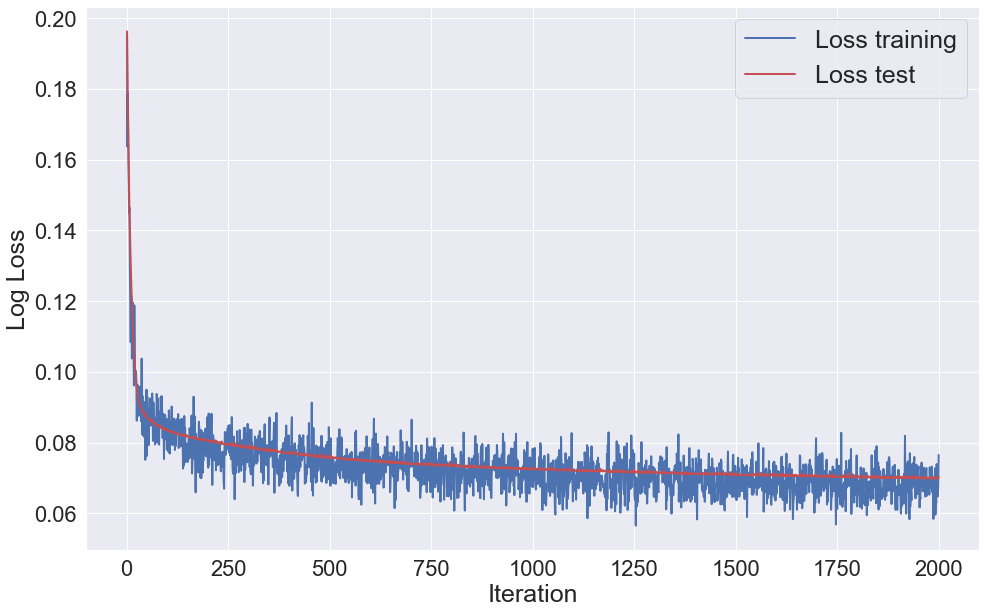

In [19]:
cost_test, cost_train = neural_net.costs()

sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

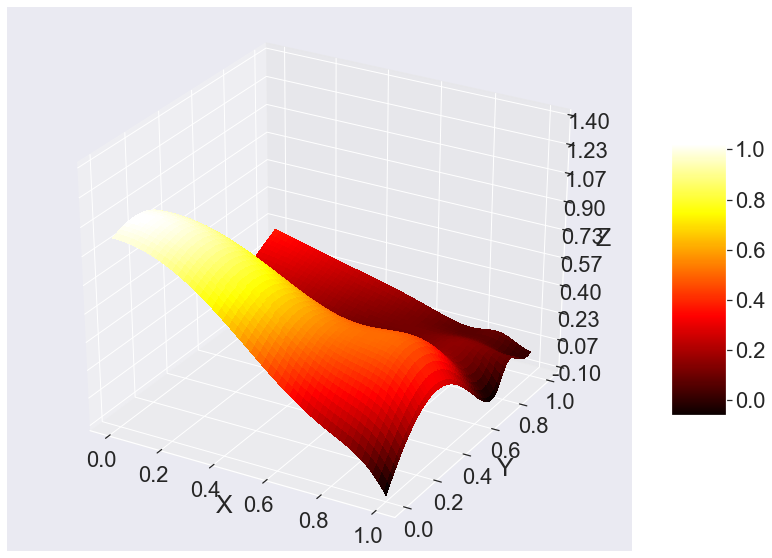

0.5388937979363471


In [20]:
pred = neural_net.feed_out(design, activation)


fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred.ravel()))

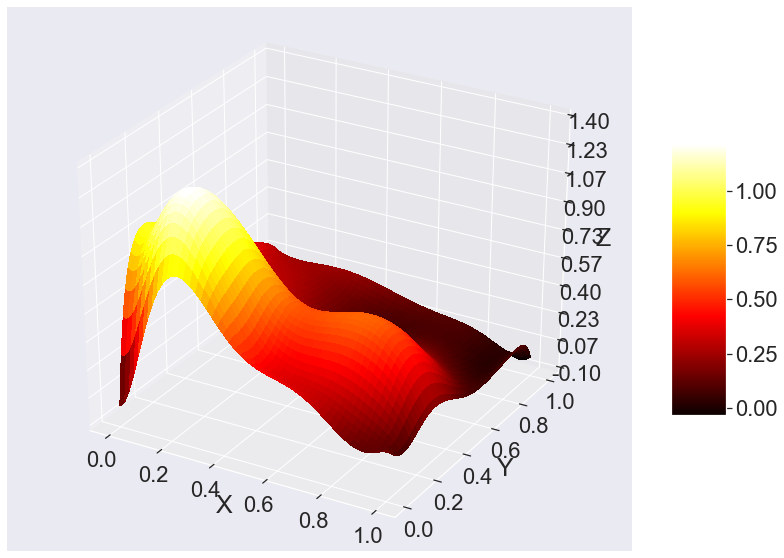

0.5781183055857548

In [22]:
beta, pred = fx.OridinaryLeastSquares(design, frank, design)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

fx.R2Score(ytest,xtest@beta)



0.552097853990936
0.563686182127991
0.5537575949592956
0.5378390936446529
0.4699448759468756
0.30149043290447386
-0.0005697428468371957
0.5666877337478484
0.5653012414142196
0.5431118394924033
0.5347667660012849
0.4604682928669024
0.2995823226172136
-0.02207023813936448


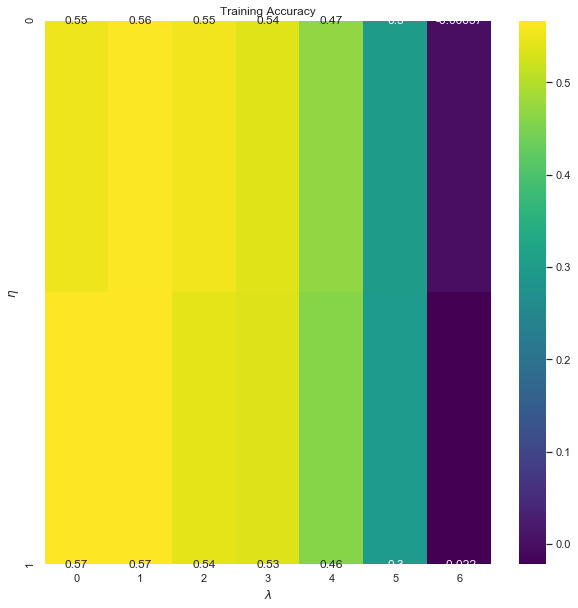

In [14]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (45,30)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [15]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.max(train_accuracy))
best_eta,best_lmb = eta_vals[best_eta_index], lmbd_vals[best_lmb_index] 
print(best_eta, 'eta')
print(best_lmb, 'lmb') 


dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=best_lmb, learning_rate_init=best_eta, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

[0.1] eta
[1.e-05] lmb
0.555387255368379


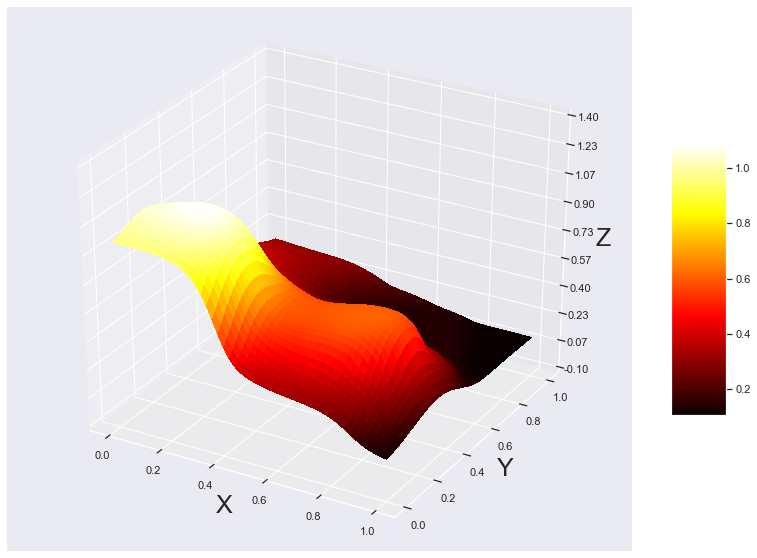

0.5607705467393966


In [16]:
pred = dnn.predict(X_train)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred))